In [1]:
import pandas as pd
##Import packages
import openai
import pandas as pd
import re
import contextlib
import io
import tiktoken
from openai.embeddings_utils import get_embedding
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px
import umap
import umap.plot
from umap import UMAP
import hdbscan


#load in the .env entries as environment varaiables
from dotenv import load_dotenv
load_dotenv()


c:\Users\noahk\anaconda3\envs\langchain_env\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\noahk\anaconda3\envs\langchain_env\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\noahk\anaconda3\envs\langchain_env\Lib\site-packages\umap\distanc

True

In [2]:
file_path = r'..\data\graph_data_final.csv'
#save a new csv
df = pd.read_csv(file_path)

In [3]:
df.describe()

,head,type,tail
count,773,773,773
unique,604,87,493
top,hal_puthoff,employer,usaf
freq,12,106,27


So we have 87 different "types" which we are wishing to make our relationships. Lets try to do some clustering to find things that are similar

In [4]:
#first lets collect unique lists of what will represent our nodes and edges
#nodes are a list of all the unique values of head and tail
nodes = pd.concat([df['head'], df['tail']]).unique()
#edges are all the type values
edges = df['type'].unique()
print(f"there are {len(nodes)} nodes and {len(edges)} edges")



there are 874 nodes and 87 edges


I want to do some clustering on the nodes and edges. each of these are a list of unique string values,so I am thinking we can use OpenAI embeddings endpoint to compute embeddings and then we can do some dimension reduction and clustering to see if we can group up similar nodes and edges. I also have an idea of our goal categories we will place these into

In [ ]:

##Set parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
top_n = 1000
encoding = tiktoken.get_encoding(embedding_encoding)
col_embedding = 'embedding'
n_tsne=2
n_iter = 1000

In [ ]:
##Gets the embedding from OpenAI
def get_embedding(text, model):
  openai.api_key = os.environ["OPENAI_API_KEY"]
  text = text.replace("\n", " ")
  return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']


In [ ]:
#lets make nodes and edges into a dataframe
nodes_df = pd.DataFrame(nodes, columns=['node'])
edges_df = pd.DataFrame(edges, columns=['edge'])
#lets remove the _ from the node and edge names
nodes_df['node'] = nodes_df['node'].apply(lambda x: x.replace('_', ' '))
edges_df['edge'] = edges_df['edge'].apply(lambda x: x.replace('_', ' '))

nodes_df['n_tokens'] = nodes_df['node'].apply(lambda x: len(encoding.encode(x)))
edges_df['n_tokens'] = edges_df['edge'].apply(lambda x: len(encoding.encode(x)))



print(f"Total number of tokens for nodes: {nodes_df['n_tokens'].sum()}")
print(f"Total number of tokens for edges: {edges_df['n_tokens'].sum()}")


nodes_df[col_embedding] = nodes_df['node'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
edges_df[col_embedding] = edges_df['edge'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

-------------------------

In [26]:
# #lets write all these to file for later use
# nodes_df.to_csv(r'..\data\nodes.csv', index=False)
# edges_df.to_csv(r'..\data\edges.csv', index=False)

nodes_df = pd.read_csv(r'..\data\nodes.csv')
edges_df = pd.read_csv(r'..\data\edges.csv')


#make sure the col_embeddings are of the correct type
nodes_df['embedding'] = nodes_df.apply(lambda x: np.array(eval(x['embedding'])), axis=1)
edges_df['embedding'] = edges_df.apply(lambda x: np.array(eval(x['embedding'])), axis=1)

In [27]:
node_matrix = np.array(nodes_df['embedding'].tolist())
edge_matrix = np.array(edges_df['embedding'].tolist())

In [28]:
####UMAP
umap_inputs = {'n_neighbors': 6,
               'min_dist': 0.1,
               'n_components': 2,
               'metric': 'euclidean',
               'target_metric': 'categorical'}
reducer = umap.UMAP( **umap_inputs)
reducer.fit(node_matrix)
#bring it back into the dataframe
embedding = reducer.transform(node_matrix)
print(embedding.shape)
#plot the results, first add the x,y to the dataframe
nodes_df['x'] = embedding[:,0]
nodes_df['y'] = embedding[:,1]

(874, 2)


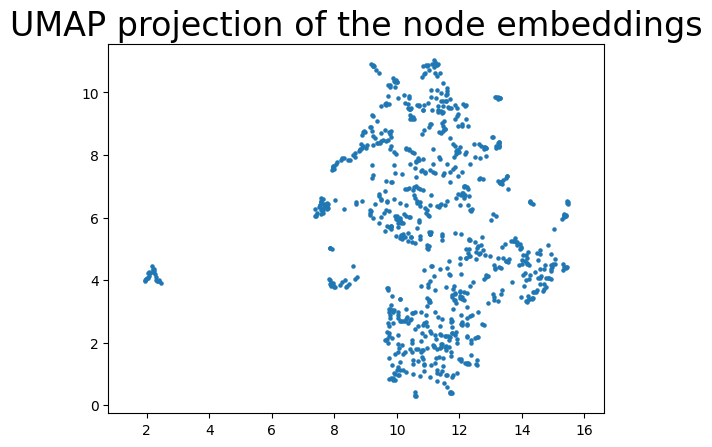

In [29]:

import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the node embeddings', fontsize=24);

What does this image show us? It is simply showing us a 2D rendering of the high dimensional embeddings that we made on all the nodes. We see that there are definately some distinct clusters coming through, we do not really know how dense these are, but there are a good amount of noise outside of the clusters. This is not too surprising since the embeddings were made on only a few words.

In [30]:
#lets use hdbscan to cluster the nodes
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, metric='euclidean')
clusterer.fit(embedding)
nodes_df['cluster'] = clusterer.labels_
#make the clusters categorical 
nodes_df['cluster'] = nodes_df['cluster'].astype('category')
#sort values by cluster
nodes_df = nodes_df.sort_values(by='cluster')

nodes_df['cluster'].value_counts()

#lets plot the clusters
fig = px.scatter(nodes_df, x="x", y="y", color="cluster", hover_data=['node'])
fig.show()

We could have been more strict in the HDBSCAN to get less groups, but my goal with this exercise is to sort based on group and it will allow me to more quickly assign the types for each node. We can really clearly see dates in its own cluster and all locations are more or less in one place, and many of the things that I would define as "objects" or "technologies" or "concepts" are what makes up some of the noise. We should also be able to much more quickly identify duplicates within our data. There are automated methods to go about cleaning this data, but I think it will be best to just comb through the 875 nodes.

SO I will make a csv and I am going to sort by cluster and then I am going to assign the following labels:

'program'  
'person'  
'position'  
'publication'    
'event'  
'place'  
'concept'  
'organization'  
'group'  
'date'  
'civilian_contractor'  
'object'  
'technology'  

In [31]:
nodes_df

,node,n_tokens,embedding,x,y,cluster
0,roswell army air field,6,"[-0.022709418088197708, -0.01616789400577545, ...",14.254712,6.506034,-1
294,us,1,"[0.014804207719862461, -0.02596471831202507, -...",10.402611,6.016804,-1
291,ernst steinhoff,5,"[-0.006640342995524406, -0.014996306970715523,...",10.166992,1.933433,-1
602,renaissance technologies llc,5,"[-0.01974639855325222, -0.010008861310780048, ...",12.475938,8.346830,-1
604,roswell nm,4,"[-0.011155695654451847, 0.005066249053925276, ...",14.372659,6.421566,-1
...,...,...,...,...,...,...
478,colm kelleher,4,"[-0.017438633367419243, -0.005774077959358692,...",11.440486,1.078441,41
519,christopher mellon,4,"[-0.02305280975997448, -0.01520328689366579, -...",11.579434,0.950791,41
736,jb michaels,4,"[-0.03838802129030228, -0.009342336095869541, ...",11.228829,1.339884,41
313,bruce maccabee,5,"[-0.040478598326444626, -0.014333268627524376,...",11.289113,1.021937,41


In [32]:
#export to a csv
nodes_df.to_csv(r'..\data\nodes.csv', index=False)

......did some manual mapping


In [34]:
#read in the fixed_nodes - noes.csv file
fixed_nodes = pd.read_csv(r'..\data\fixed_nodes - nodes.csv')

In [38]:
#join fixed_nodes to nodes_df
nodes_df = nodes_df.merge(fixed_nodes[['node','type','real_value']], on='node', how='left')

In [39]:
nodes_df

,node,n_tokens,embedding,x,y,cluster,type,real_value
0,roswell army air field,6,"[-0.022709418088197708, -0.01616789400577545, ...",14.254712,6.506034,-1,place,NaN
1,us,1,"[0.014804207719862461, -0.02596471831202507, -...",10.402611,6.016804,-1,place,NaN
2,ernst steinhoff,5,"[-0.006640342995524406, -0.014996306970715523,...",10.166992,1.933433,-1,person,NaN
3,renaissance technologies llc,5,"[-0.01974639855325222, -0.010008861310780048, ...",12.475938,8.346830,-1,organization,NaN
4,roswell nm,4,"[-0.011155695654451847, 0.005066249053925276, ...",14.372659,6.421566,-1,place,roswell nm
...,...,...,...,...,...,...,...,...
869,colm kelleher,4,"[-0.017438633367419243, -0.005774077959358692,...",11.440486,1.078441,41,person,NaN
870,christopher mellon,4,"[-0.02305280975997448, -0.01520328689366579, -...",11.579434,0.950791,41,person,NaN
871,jb michaels,4,"[-0.03838802129030228, -0.009342336095869541, ...",11.228829,1.339884,41,person,NaN
872,bruce maccabee,5,"[-0.040478598326444626, -0.014333268627524376,...",11.289113,1.021937,41,person,NaN


I realize now we will be unable to fit it back to the original dataset because we removed stuff and didnt keep the original :P 

In [41]:
orig_df = pd.read_csv(r'..\data\graph_data_final.csv')
orig_df

,head,type,tail
0,roswell_army_air_field,place_served_by_transport_hub,roswell_nm
1,roswell_morning_dispatch,editor,arthur_r_mcquiddy
2,fort_worth_army_air_field,located_in_the_administrative_territorial_entity,nm
3,9_july_1991_entry,point_in_time,9_july_1991
4,flying_saucer,subclass_of,uap
...,...,...,...
768,renaissance_technologies_llc,headquarters_location,austin_tx
769,john_greenwald,employer,national_reconnaissance_office
770,egg,subsidiary,area_51
771,area_51,parent_organization,egg


In [42]:
#original  data 
orig_df = pd.read_csv(r'..\data\graph_data_final.csv')

nodes = pd.concat([df['head'], df['tail']]).unique()
#edges are all the type values
edges = df['type'].unique()
#we need to do the same manipulations we did 
#these were the things we did
# text = text.replace("\n", " ")
# .apply(lambda x: x.replace('_', ' '))

#so lets keep the original and make an edited version in a new column
#first make a dataframe of the nodes and edges
nodes_df_original = pd.DataFrame(nodes, columns=['node'])
edges_df_original = pd.DataFrame(edges, columns=['edge'])

nodes_df_original['node_edited'] = nodes_df_original['node'].apply(lambda x: x.replace('_', ' '))
nodes_df_original['node_edited'] = nodes_df_original['node_edited'].apply(lambda x: x.replace('\n', ' '))

In [46]:
#ok now join the nodes_df to the nodes_df_original
nodes_almost_final = nodes_df.merge(nodes_df_original[['node','node_edited']], left_on='node',right_on = 'node_edited', how='left')

In [50]:
#ok, now we need re replace the node_edited with the real_value if it exists. So basically I want it to 
nodes_almost_final.node_edited = nodes_almost_final.apply(lambda x: x['real_value'] if pd.notnull(x['real_value']) else x['node_edited'], axis=1)

In [55]:
#drop dupliacates based on node_edited
nodes_final = nodes_almost_final.drop_duplicates(subset=['node_edited'])
nodes_final = nodes_final[['node_y','node_edited','type']].rename(columns={'node_y':'node'})
nodes_final


,node,node_edited,type
0,roswell_army_air_field,roswell army air field,place
1,us,us,place
2,ernst_steinhoff,ernst steinhoff,person
3,renaissance_technologies_llc,renaissance technologies llc,organization
4,roswell_nm,roswell nm,place
...,...,...,...
869,colm_kelleher,colm kelleher,person
870,christopher_mellon,christopher mellon,person
871,jb_michaels,jb michaels,person
872,bruce_maccabee,bruce maccabee,person


In [56]:
import json

# Initialize empty lists
nodes_list = []
edges_list = []

# Populate nodes
for idx, row in nodes_final.iterrows():
    node = {
        'id': row['node'],
        'type': row['type'],
        'node_edited': row['node_edited']
    }
    nodes_list.append(node)

# Populate edges
for idx, row in orig_df.iterrows():
    edge = {
        'source': row['head'],
        'target': row['tail'],
        'relationship_type': row['type']
    }
    edges_list.append(edge)

# Combine into one JSON object
graph_json = {
    'nodes': nodes_list,
    'edges': edges_list
}

# Write to file
with open('graph_data.json', 'w') as f:
    json.dump(graph_json, f)
